#### Installing statsmodels


The easiest way to install statsmodels is to install it as part of the Anaconda distribution, a cross-platform distribution for data analysis and scientific computing. This is the recommended installation method for most users.

Instructions for installing from PyPI, source or a development version are also provided.

Python Support
statsmodels supports Python 3.7, 3.8, and 3.9.

Anaconda
statsmodels is available through conda provided by Anaconda. The latest release can be installed using:

conda install -c conda-forge statsmodels
PyPI (pip)
To obtain the latest released version of statsmodels using pip:

pip install statsmodels
Follow this link to our PyPI page to directly download wheels or source.

In [1]:
import statsmodels.api as sm
import pandas
from patsy import dmatrices

pandas builds on numpy arrays to provide rich data structures and data analysis tools. The pandas.DataFrame function provides labelled arrays of (potentially heterogenous) data, similar to the R “data.frame”. The pandas.read_csv function can be used to convert a comma-separated values file to a DataFrame object.

patsy is a Python library for describing statistical models and building Design Matrices using R-like formulas.

##### Data
We download the Guerry dataset, a collection of historical data used in support of Andre-Michel Guerry’s 1833 Essay on the Moral Statistics of France. The data set is hosted online in comma-separated values format (CSV) by the Rdatasets repository. We could download the file locally and then load it using read_csv, but pandas takes care of all of this automatically for us:

In [2]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

We select the variables of interest and look at the bottom 5 rows:


In [4]:
vars = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']

In [5]:
df = df[vars]

In [6]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C
85,Corse,83,49,37,NaN


Notice that there is one missing observation in the Region column. We eliminate it using a DataFrame method provided by pandas:

In [8]:
#delete missing data
df = df.dropna()

In [9]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
80,Vendee,68,28,56,W
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C


#### Substantive motivation and model
We want to know whether literacy rates in the 86 French departments are associated with per capita wagers on the Royal Lottery in the 1820s. We need to control for the level of wealth in each department, and we also want to include a series of dummy variables on the right-hand side of our regression equation to control for unobserved heterogeneity due to regional effects. The model is estimated using ordinary least squares regression (OLS).

#### Design matrices (endog & exog)
To fit most of the models covered by statsmodels, you will need to create two design matrices. The first is a matrix of endogenous variable(s) (i.e. dependent, response, regressand, etc.). The second is a matrix of exogenous variable(s) (i.e. independent, predictor, regressor, etc.). The OLS coefficient estimates are calculated as usual:



<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>&#x3B2;</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>X</mi>
    <mo data-mjx-alternate="1">&#x2032;</mo>
  </msup>
  <mi>X</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
  <msup>
    <mi>X</mi>
    <mo data-mjx-alternate="1">&#x2032;</mo>
  </msup>
  <mi>y</mi>
</math>

where <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>y</mi>
</math> is an N \times 1 column of data on lottery wagers per capita (Lottery). <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>X</mi>
</math> is <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>N</mi>
  <mo>&#xD7;</mo>
  <mn>7</mn>
</math> with an intercept, the Literacy and Wealth variables, and 4 region binary variables.

The `patsy` module provides a convenient function to prepare design matrices using R-like formulas. You can find more information here.

We use `patsy’s dmatrices` function to create design matrices:

In [11]:
y, X = dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')

In [12]:
y[:3]

,Lottery
0,41.0
1,38.0
2,66.0


In [13]:
X[:3]

,Intercept,Region[T.E],Region[T.N],Region[T.S],Region[T.W],Literacy,Wealth
0,1.0,1.0,0.0,0.0,0.0,37.0,73.0
1,1.0,0.0,1.0,0.0,0.0,51.0,22.0
2,1.0,0.0,0.0,0.0,0.0,13.0,61.0


Notice that dmatrices has

split the categorical Region variable into a set of indicator variables.

added a constant to the exogenous regressors matrix.

returned pandas DataFrames instead of simple numpy arrays. This is useful because DataFrames allow statsmodels to carry-over meta-data (e.g. variable names) when reporting results.

### Model fit and summary
Fitting a model in statsmodels typically involves 3 easy steps:

Use the model class to describe the model

Fit the model using a class method

Inspect the results using a summary method

For OLS, this is achieved by:

In [14]:
mod = sm.OLS(y, X)    # Describe model

In [15]:
res = mod.fit()       # Fit model

In [16]:
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           1.07e-05
Time:                        11:35:58   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

The `res` object has many useful attributes. For example, we can extract parameter estimates and r-squared by typing:

In [17]:
res.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

In [18]:
sm.stats.linear_rainbow(res)

(0.847233997615691, 0.6997965543621644)

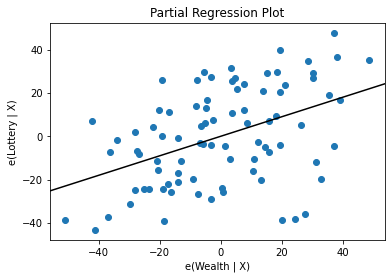

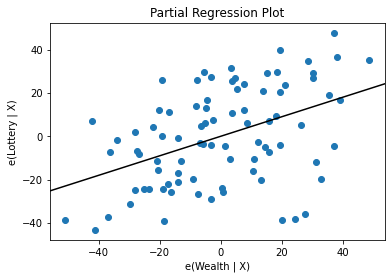

In [19]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'],data=df, obs_labels=False)